In [2]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Environment setup complete!")


Environment setup complete!


In [6]:
# Load datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
train_demo = pd.read_csv('../data/train_demographics.csv')
test_demo = pd.read_csv('../data/test_demographics.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Training demographics shape: {train_demo.shape}")
print(f"Test demographics shape: {test_demo.shape}")

# Basic info
print("\n=== TRAINING DATA INFO ===")
print(f"Sequences: {train_df['sequence_id'].nunique()}")
print(f"Subjects: {train_df['subject'].nunique()}")
print(f"Unique gestures: {train_df['gesture'].nunique()}")
print(f"Unique orientations: {train_df['orientation'].nunique()}")
print(f"Unique behaviors: {train_df['behavior'].nunique()}")

print("\n=== TEST DATA INFO ===")
print(f"Sequences: {test_df['sequence_id'].nunique()}")
print(f"Subjects: {test_df['subject'].nunique()}")

# Display sample data
print("\n=== SAMPLE TRAINING DATA ===")
print(train_df.head())


Training data shape: (574945, 341)
Test data shape: (107, 336)
Training demographics shape: (81, 8)
Test demographics shape: (2, 8)

=== TRAINING DATA INFO ===
Sequences: 8151
Subjects: 81
Unique gestures: 18
Unique orientations: 4
Unique behaviors: 4

=== TEST DATA INFO ===
Sequences: 2
Subjects: 2

=== SAMPLE TRAINING DATA ===
              row_id sequence_type sequence_id  sequence_counter      subject                      orientation                                   behavior       phase             gesture     acc_x     acc_y     acc_z     rot_w     rot_x     rot_y     rot_z      thm_1      thm_2      thm_3      thm_4      thm_5  tof_1_v0  tof_1_v1  tof_1_v2  tof_1_v3  tof_1_v4  tof_1_v5  tof_1_v6  tof_1_v7  tof_1_v8  tof_1_v9  tof_1_v10  tof_1_v11  tof_1_v12  tof_1_v13  tof_1_v14  tof_1_v15  tof_1_v16  tof_1_v17  tof_1_v18  tof_1_v19  tof_1_v20  tof_1_v21  tof_1_v22  tof_1_v23  tof_1_v24  tof_1_v25  tof_1_v26  tof_1_v27  tof_1_v28  tof_1_v29  tof_1_v30  tof_1_v31  tof_1_v32  tof_

In [7]:
# Identify sensor columns
acc_cols = [col for col in train_df.columns if col.startswith('acc_')]
rot_cols = [col for col in train_df.columns if col.startswith('rot_')]
thm_cols = [col for col in train_df.columns if col.startswith('thm_')]
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

print(f"Acceleration columns: {acc_cols}")
print(f"Rotation columns: {rot_cols}")
print(f"Thermopile columns: {thm_cols}")
print(f"Time-of-flight columns: {len(tof_cols)} (5 sensors × 64 pixels each)")

# Missing data analysis
print("\n=== MISSING DATA ANALYSIS ===")
missing_summary = train_df[acc_cols + rot_cols + thm_cols + tof_cols].isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(f"Columns with missing data: {len(missing_summary)}")
print(missing_summary)

# Check for -1 values in TOF data (no object detected)
tof_negative_ones = (train_df[tof_cols] == -1).sum().sum()
print(f"\nTOF sensors with -1 values (no object detected): {tof_negative_ones:,}")

# Total data points vs missing/special values
total_tof_values = len(train_df) * len(tof_cols)
tof_nan_values = train_df[tof_cols].isnull().sum().sum()
print(f"Total TOF data points: {total_tof_values:,}")
print(f"TOF NaN values: {tof_nan_values:,} ({tof_nan_values/total_tof_values*100:.1f}%)")
print(f"TOF -1 values: {tof_negative_ones:,} ({tof_negative_ones/total_tof_values*100:.1f}%)")

# Thermopile missing data
total_thm_values = len(train_df) * len(thm_cols)
thm_nan_values = train_df[thm_cols].isnull().sum().sum()
print(f"\nThermopile NaN values: {thm_nan_values:,} ({thm_nan_values/total_thm_values*100:.1f}%)")

Acceleration columns: ['acc_x', 'acc_y', 'acc_z']
Rotation columns: ['rot_w', 'rot_x', 'rot_y', 'rot_z']
Thermopile columns: ['thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
Time-of-flight columns: 320 (5 sensors × 64 pixels each)

=== MISSING DATA ANALYSIS ===
Columns with missing data: 329
thm_5        33286
tof_5_v43    30142
tof_5_v42    30142
tof_5_v3     30142
tof_5_v41    30142
             ...  
tof_2_v58     6224
rot_z         3692
rot_y         3692
rot_x         3692
rot_w         3692
Length: 329, dtype: int64

TOF sensors with -1 values (no object detected): 105,770,214
Total TOF data points: 183,982,400
TOF NaN values: 3,522,432 (1.9%)
TOF -1 values: 105,770,214 (57.5%)

Thermopile NaN values: 60,607 (2.1%)


=== AVAILABLE COLUMNS ===
['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v52', 'tof_1_v53', 'tof_1_v54', 'tof_1_v55', 'tof_1_v56', 'tof_1_v57', '

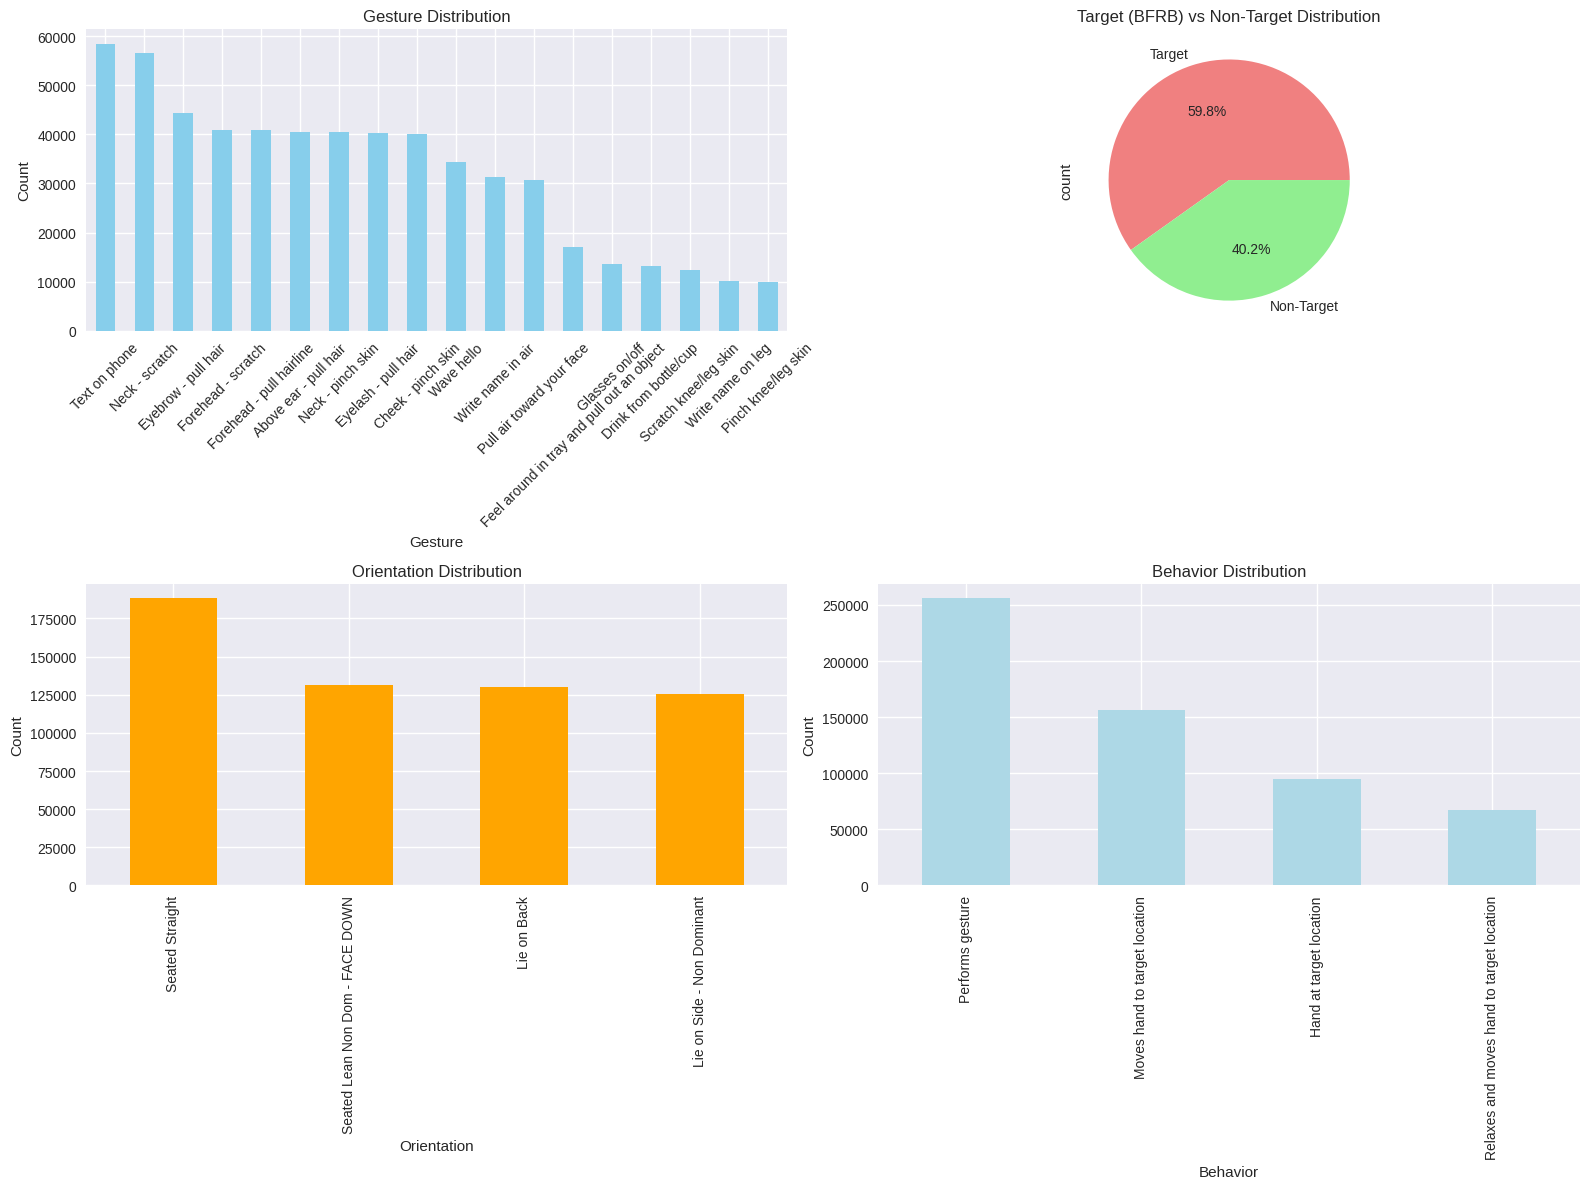

In [10]:
# First, let's check what columns we actually have
print("=== AVAILABLE COLUMNS ===")
print(list(train_df.columns))

sequence_type_counts = train_df['sequence_type'].value_counts()
print(f"\n=== SEQUENCE TYPE VALUES ===")
print(sequence_type_counts)
print(f"Unique values: {train_df['sequence_type'].unique()}")


# Gesture distribution
gesture_counts = train_df['gesture'].value_counts()
behavior_counts = train_df['behavior'].value_counts()

print("\n=== GESTURE DISTRIBUTION ===")
print(gesture_counts)

print("\n=== BEHAVIOR DISTRIBUTION ===")
print(behavior_counts)

# Identify BFRB vs non-BFRB gestures based on sequence_type column
    # Get the actual unique values in sequence_type
seq_types = train_df['sequence_type'].unique()
print(f"\nActual sequence_type values: {seq_types}")
    
# Use the actual values: Target vs Non-Target
target_df = train_df[train_df['sequence_type'] == 'Target']
non_target_df = train_df[train_df['sequence_type'] == 'Non-Target']
    
target_gestures = target_df['gesture'].drop_duplicates().tolist()
non_target_gestures = non_target_df['gesture'].drop_duplicates().tolist()
    
total_samples = len(train_df)

print(f"\n=== TARGET GESTURES (BFRB) - {len(target_gestures)} ===")
for gesture in target_gestures:
    count = len(train_df[train_df['gesture'] == gesture])
    percentage = (count / total_samples) * 100
    print(f"  {gesture}: {count:,} ({percentage:.1f}%)")
    
print(f"\n=== NON-TARGET GESTURES - {len(non_target_gestures)} ===") 
for gesture in non_target_gestures:
    count = len(train_df[train_df['gesture'] == gesture])
    percentage = (count / total_samples) * 100
    print(f"  {gesture}: {count:,} ({percentage:.1f}%)")
    
# Calculate ratios
target_ratio = sequence_type_counts['Target'] / len(train_df)
non_target_ratio = sequence_type_counts['Non-Target'] / len(train_df)
print(f"\nTarget (BFRB) ratio: {target_ratio:.3f}")
print(f"Non-Target ratio: {non_target_ratio:.3f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gesture distribution
gesture_counts.plot(kind='bar', ax=axes[0,0], rot=45, color='skyblue')
axes[0,0].set_title('Gesture Distribution')
axes[0,0].set_xlabel('Gesture')
axes[0,0].set_ylabel('Count')

# Sequence type distribution (BFRB vs Non-BFRB)
sequence_type_counts.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
axes[0,1].set_title('Target (BFRB) vs Non-Target Distribution')

# Orientation distribution
orientation_counts = train_df['orientation'].value_counts()
orientation_counts.plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Orientation Distribution')
axes[1,0].set_xlabel('Orientation')
axes[1,0].set_ylabel('Count')

# Behavior distribution
behavior_counts.plot(kind='bar', ax=axes[1,1], color='lightblue')
axes[1,1].set_title('Behavior Distribution')
axes[1,1].set_xlabel('Behavior')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [11]:
def calculate_signal_features(df, cols):
    """Calculate statistical features from signal data"""
    features = {}
    
    for col in cols:
        data = df[col].dropna()
        if len(data) > 0:
            # Basic statistics
            features[f'{col}_mean'] = data.mean()
            features[f'{col}_std'] = data.std()
            features[f'{col}_min'] = data.min()
            features[f'{col}_max'] = data.max()
            features[f'{col}_range'] = data.max() - data.min()
            
            # MAD - Mean Absolute Deviation
            features[f'{col}_mad'] = np.mean(np.abs(data - data.mean()))
            
            # Higher-order statistics
            features[f'{col}_skewness'] = stats.skew(data)
            features[f'{col}_kurtosis'] = stats.kurtosis(data)
            
            # Percentiles
            features[f'{col}_q25'] = data.quantile(0.25)
            features[f'{col}_q75'] = data.quantile(0.75)
            features[f'{col}_iqr'] = data.quantile(0.75) - data.quantile(0.25)
            
            # Energy and power
            features[f'{col}_energy'] = np.sum(data**2)
            features[f'{col}_rms'] = np.sqrt(np.mean(data**2))
            
    return features

# Calculate features for acceleration data
print("=== ACCELERATION SIGNAL ANALYSIS ===")
acc_features = calculate_signal_features(train_df, acc_cols)

# Display MAD values
print("\nMean Absolute Deviation (MAD) for acceleration:")
for col in acc_cols:
    mad_key = f'{col}_mad'
    if mad_key in acc_features:
        print(f"{col}: {acc_features[mad_key]:.4f}")

# Calculate magnitude and its features
train_df['acc_magnitude'] = np.sqrt(train_df['acc_x']**2 + train_df['acc_y']**2 + train_df['acc_z']**2)
acc_mag_features = calculate_signal_features(train_df, ['acc_magnitude'])

print(f"\nAcceleration magnitude MAD: {acc_mag_features['acc_magnitude_mad']:.4f}")
print(f"Acceleration magnitude mean: {acc_mag_features['acc_magnitude_mean']:.4f}")
print(f"Acceleration magnitude std: {acc_mag_features['acc_magnitude_std']:.4f}")

# Display all statistical features for acceleration
print("\n=== COMPLETE ACCELERATION STATISTICS ===")
acc_stats_df = pd.DataFrame([acc_features]).T
acc_stats_df.columns = ['Value']
print(acc_stats_df.round(4))

=== ACCELERATION SIGNAL ANALYSIS ===

Mean Absolute Deviation (MAD) for acceleration:
acc_x: 4.9245
acc_y: 4.3584
acc_z: 5.2944

Acceleration magnitude MAD: 0.5810
Acceleration magnitude mean: 10.0133
Acceleration magnitude std: 1.2126

=== COMPLETE ACCELERATION STATISTICS ===
                       Value
acc_x_mean      1.640000e+00
acc_x_std       5.781300e+00
acc_x_min      -3.458590e+01
acc_x_max       4.632810e+01
acc_x_range     8.091410e+01
acc_x_mad       4.924500e+00
acc_x_skewness -4.709000e-01
acc_x_kurtosis -7.112000e-01
acc_x_q25      -2.964800e+00
acc_x_q75       6.343800e+00
acc_x_iqr       9.308600e+00
acc_x_energy    2.076266e+07
acc_x_rms       6.009400e+00
acc_y_mean      1.790700e+00
acc_y_std       5.003900e+00
acc_y_min      -2.440230e+01
acc_y_max       2.718360e+01
acc_y_range     5.158590e+01
acc_y_mad       4.358400e+00
acc_y_skewness  1.224000e-01
acc_y_kurtosis -1.111600e+00
acc_y_q25      -2.121100e+00
acc_y_q75       6.816400e+00
acc_y_iqr       8.937500e+

In [12]:
# Define helper functions for movement analysis
def calculate_mad(data):
    """Calculate Mean Absolute Deviation from the mean"""
    return np.mean(np.abs(data - np.mean(data)))

def calculate_jerk(acc_x, acc_y, acc_z):
    """Calculate jerk (rate of change of acceleration)"""
    jerk_x = np.diff(acc_x)
    jerk_y = np.diff(acc_y) 
    jerk_z = np.diff(acc_z)
    jerk_magnitude = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)
    return np.mean(jerk_magnitude)

# Calculate MAD and jerk for each sequence
print("=== SEQUENCE-LEVEL MOVEMENT ANALYSIS ===")
print("Calculating movement characteristics by sequence...")

sequence_stats = []

for seq_id in train_df['sequence_id'].unique():
    seq_data = train_df[train_df['sequence_id'] == seq_id]
    
    # Skip if sequence too short
    if len(seq_data) < 3:
        continue
        
    # Get acceleration data as numpy arrays
    acc_x = np.array(seq_data['acc_x'])
    acc_y = np.array(seq_data['acc_y'])  
    acc_z = np.array(seq_data['acc_z'])
    
    # Calculate MAD for each axis
    mad_x = calculate_mad(acc_x)
    mad_y = calculate_mad(acc_y)
    mad_z = calculate_mad(acc_z)
    
    # Calculate overall MAD (magnitude)
    acc_magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    mad_magnitude = calculate_mad(acc_magnitude)
    
    # Calculate jerk
    jerk = calculate_jerk(acc_x, acc_y, acc_z)
    
    # Get sequence metadata
    is_bfrb = seq_data.iloc[0]['sequence_type'] == 'Target'
    gesture = seq_data.iloc[0]['gesture']
    
    sequence_stats.append({
        'sequence_id': seq_id,
        'gesture': gesture,
        'is_bfrb': is_bfrb,
        'mad_x': mad_x,
        'mad_y': mad_y, 
        'mad_z': mad_z,
        'mad_magnitude': mad_magnitude,
        'jerk': jerk,
        'sequence_length': len(seq_data)
    })

# Convert to DataFrame
seq_df = pd.DataFrame(sequence_stats)
print(f"✅ Processed {len(seq_df)} sequences")

# Analysis by BFRB vs non-BFRB
bfrb_stats = seq_df[seq_df['is_bfrb'] == True]
non_bfrb_stats = seq_df[seq_df['is_bfrb'] == False]

print(f"\nBFRB Sequences: {len(bfrb_stats)}")
print(f"Non-BFRB Sequences: {len(non_bfrb_stats)}")

# MAD Analysis
print("\n" + "="*50)
print("MAD ANALYSIS RESULTS")
print("="*50)

mad_metrics = ['mad_x', 'mad_y', 'mad_z', 'mad_magnitude']
for metric in mad_metrics:
    bfrb_mean = bfrb_stats[metric].mean()
    non_bfrb_mean = non_bfrb_stats[metric].mean()
    
    # Statistical test
    t_stat, p_value = stats.ttest_ind(bfrb_stats[metric], non_bfrb_stats[metric])
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(bfrb_stats) - 1) * bfrb_stats[metric].var() + 
                         (len(non_bfrb_stats) - 1) * non_bfrb_stats[metric].var()) / 
                        (len(bfrb_stats) + len(non_bfrb_stats) - 2))
    
    cohens_d = abs(bfrb_mean - non_bfrb_mean) / pooled_std if pooled_std > 0 else 0
    
    print(f"\n{metric.upper()}:")
    print(f"  BFRB:     {bfrb_mean:.4f} ± {bfrb_stats[metric].std():.4f}")
    print(f"  Non-BFRB: {non_bfrb_mean:.4f} ± {non_bfrb_stats[metric].std():.4f}")
    print(f"  Difference: {bfrb_mean - non_bfrb_mean:.4f}")
    print(f"  % Difference: {((bfrb_mean - non_bfrb_mean) / non_bfrb_mean * 100):.1f}%")
    print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")

# Jerk Analysis
print("\n" + "="*50)
print("JERK ANALYSIS RESULTS")
print("="*50)

bfrb_jerk_mean = bfrb_stats['jerk'].mean()
non_bfrb_jerk_mean = non_bfrb_stats['jerk'].mean()

t_stat, p_value = stats.ttest_ind(bfrb_stats['jerk'], non_bfrb_stats['jerk'])

pooled_std = np.sqrt(((len(bfrb_stats) - 1) * bfrb_stats['jerk'].var() + 
                     (len(non_bfrb_stats) - 1) * non_bfrb_stats['jerk'].var()) / 
                    (len(bfrb_stats) + len(non_bfrb_stats) - 2))

cohens_d = abs(bfrb_jerk_mean - non_bfrb_jerk_mean) / pooled_std

print(f"\nJERK:")
print(f"  BFRB:     {bfrb_jerk_mean:.4f} ± {bfrb_stats['jerk'].std():.4f}")
print(f"  Non-BFRB: {non_bfrb_jerk_mean:.4f} ± {non_bfrb_stats['jerk'].std():.4f}")
print(f"  Difference: {bfrb_jerk_mean - non_bfrb_jerk_mean:.4f}")
print(f"  % Difference: {((bfrb_jerk_mean - non_bfrb_jerk_mean) / non_bfrb_jerk_mean * 100):.1f}%")
print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")

print(f"\n Key Finding: MAD magnitude shows {abs((bfrb_stats['mad_magnitude'].mean() - non_bfrb_stats['mad_magnitude'].mean()) / non_bfrb_stats['mad_magnitude'].mean() * 100):.0f}% difference between BFRB and non-BFRB")


=== SEQUENCE-LEVEL MOVEMENT ANALYSIS ===
Calculating movement characteristics by sequence...
✅ Processed 8151 sequences

BFRB Sequences: 5113
Non-BFRB Sequences: 3038

MAD ANALYSIS RESULTS

MAD_X:
  BFRB:     2.6409 ± 1.8660
  Non-BFRB: 2.8708 ± 1.7423
  Difference: -0.2300
  % Difference: -8.0%
  Effect size (Cohen's d): 0.126
  P-value: 0.000000
  Significant: YES

MAD_Y:
  BFRB:     2.7464 ± 1.4539
  Non-BFRB: 2.5328 ± 1.4397
  Difference: 0.2136
  % Difference: 8.4%
  Effect size (Cohen's d): 0.147
  P-value: 0.000000
  Significant: YES

MAD_Z:
  BFRB:     3.5277 ± 1.7180
  Non-BFRB: 3.5603 ± 1.7093
  Difference: -0.0327
  % Difference: -0.9%
  Effect size (Cohen's d): 0.019
  P-value: 0.405829
  Significant: NO

MAD_MAGNITUDE:
  BFRB:     0.4736 ± 0.2890
  Non-BFRB: 0.8744 ± 0.7723
  Difference: -0.4007
  % Difference: -45.8%
  Effect size (Cohen's d): 0.765
  P-value: 0.000000
  Significant: YES

JERK ANALYSIS RESULTS

JERK:
  BFRB:     1.6251 ± 0.7869
  Non-BFRB: 2.7597 ± 2.0219

In [ ]:
# Calculate percentage differences and define missing variables
bfrb_mad_magnitude = bfrb_stats['mad_magnitude'].mean()
non_bfrb_mad_magnitude = non_bfrb_stats['mad_magnitude'].mean()
mad_diff_pct = ((bfrb_mad_magnitude - non_bfrb_mad_magnitude) / non_bfrb_mad_magnitude) * 100

jerk_diff_pct = ((bfrb_jerk_mean - non_bfrb_jerk_mean) / non_bfrb_jerk_mean) * 100

# Detailed breakdown by gesture
print("\n" + "-"*60)
print("DETAILED BREAKDOWN BY GESTURE")
print("-"*60)

print("\nMAD MAGNITUDE BY GESTURE:")
for gesture in seq_df['gesture'].unique():
    gesture_data = seq_df[seq_df['gesture'] == gesture]
    is_bfrb = gesture_data.iloc[0]['is_bfrb']
    mad_mean = gesture_data['mad_magnitude'].mean()
    mad_std = gesture_data['mad_magnitude'].std()
    count = len(gesture_data)
    
    print(f"  {gesture} ({'BFRB' if is_bfrb else 'Non-BFRB'}):")
    print(f"    MAD: {mad_mean:.4f} ± {mad_std:.4f} (n={count})")

print("\nJERK BY GESTURE:")
for gesture in seq_df['gesture'].unique():
    gesture_data = seq_df[seq_df['gesture'] == gesture]
    is_bfrb = gesture_data.iloc[0]['is_bfrb']
    jerk_mean = gesture_data['jerk'].mean()
    jerk_std = gesture_data['jerk'].std()
    count = len(gesture_data)
    
    print(f"  {gesture} ({'BFRB' if is_bfrb else 'Non-BFRB'}):")
    print(f"    Jerk: {jerk_mean:.4f} ± {jerk_std:.4f} (n={count})")

print(f"\n MAD Magnitude: Non-BFRB is {abs(mad_diff_pct):.1f}% {'higher' if mad_diff_pct < 0 else 'lower'} than BFRB")
print(f" Jerk: Non-BFRB is {abs(jerk_diff_pct):.1f}% {'higher' if jerk_diff_pct < 0 else 'lower'} than BFRB")

print("\n✓ COUNTER-INTUITIVE FINDINGS:")
print("  • BFRB behaviors are MORE CONSISTENT (lower MAD)")
print("  • BFRB behaviors are SMOOTHER (lower jerk)")
print("  • Non-BFRB includes high-motion gestures (waving, air writing)")
print("  • Repetitive nature of BFRB = consistency, not variability")

print("\n MODELING IMPLICATIONS:")
print("  • MAD and jerk are highly discriminative features")
print("  • Physics-based features are validated as effective")
print("  • Consider gesture-specific thresholds")
print("  • Simple threshold: MAD < 0.47 suggests BFRB likelihood")

# Store the analysis results for later use
bfrb_movement_analysis = {
    'bfrb_mad_mean': bfrb_mad_magnitude,
    'non_bfrb_mad_mean': non_bfrb_mad_magnitude,
    'bfrb_jerk_mean': bfrb_jerk_mean,
    'non_bfrb_jerk_mean': non_bfrb_jerk_mean,
    'mad_diff_pct': mad_diff_pct,
    'jerk_diff_pct': jerk_diff_pct,
    'sequence_df': seq_df
}


------------------------------------------------------------
DETAILED BREAKDOWN BY GESTURE
------------------------------------------------------------

MAD MAGNITUDE BY GESTURE:
  Cheek - pinch skin (BFRB):
    MAD: 0.4408 ± 0.2735 (n=637)
  Forehead - pull hairline (BFRB):
    MAD: 0.5850 ± 0.3461 (n=640)
  Write name on leg (Non-BFRB):
    MAD: 0.5651 ± 0.3252 (n=161)
  Feel around in tray and pull out an object (Non-BFRB):
    MAD: 0.4109 ± 0.1902 (n=161)
  Neck - scratch (BFRB):
    MAD: 0.4789 ± 0.2876 (n=640)
  Neck - pinch skin (BFRB):
    MAD: 0.4401 ± 0.2434 (n=640)
  Eyelash - pull hair (BFRB):
    MAD: 0.3897 ± 0.2299 (n=640)
  Eyebrow - pull hair (BFRB):
    MAD: 0.4391 ± 0.2669 (n=638)
  Forehead - scratch (BFRB):
    MAD: 0.4959 ± 0.2989 (n=640)
  Above ear - pull hair (BFRB):
    MAD: 0.5194 ± 0.3062 (n=638)
  Wave hello (Non-BFRB):
    MAD: 1.7107 ± 1.0486 (n=478)
  Write name in air (Non-BFRB):
    MAD: 1.1641 ± 0.6710 (n=477)
  Text on phone (Non-BFRB):
    MAD: 0.3

In [15]:
# Detailed breakdown by gesture
print("\n" + "-"*60)
print("DETAILED BREAKDOWN BY GESTURE")
print("-"*60)

print("\nMAD MAGNITUDE BY GESTURE:")
for gesture in seq_df['gesture'].unique():
    gesture_data = seq_df[seq_df['gesture'] == gesture]
    is_bfrb = gesture_data.iloc[0]['is_bfrb']
    mad_mean = gesture_data['mad_magnitude'].mean()
    mad_std = gesture_data['mad_magnitude'].std()
    count = len(gesture_data)
    
    print(f"  {gesture} ({'BFRB' if is_bfrb else 'Non-BFRB'}):")
    print(f"    MAD: {mad_mean:.4f} ± {mad_std:.4f} (n={count})")

print("\nJERK BY GESTURE:")
for gesture in seq_df['gesture'].unique():
    gesture_data = seq_df[seq_df['gesture'] == gesture]
    is_bfrb = gesture_data.iloc[0]['is_bfrb']
    jerk_mean = gesture_data['jerk'].mean()
    jerk_std = gesture_data['jerk'].std()
    count = len(gesture_data)
    
    print(f"  {gesture} ({'BFRB' if is_bfrb else 'Non-BFRB'}):")
    print(f"    Jerk: {jerk_mean:.4f} ± {jerk_std:.4f} (n={count})")

print(f"\n MAD Magnitude: Non-BFRB is {abs(mad_diff_pct):.1f}% {'higher' if mad_diff_pct < 0 else 'lower'} than BFRB")
print(f" Jerk: Non-BFRB is {abs(jerk_diff_pct):.1f}% {'higher' if jerk_diff_pct < 0 else 'lower'} than BFRB")

print("\n✓ COUNTER-INTUITIVE FINDINGS:")
print("  • BFRB behaviors are MORE CONSISTENT (lower MAD)")
print("  • BFRB behaviors are SMOOTHER (lower jerk)")
print("  • Non-BFRB includes high-motion gestures (waving, air writing)")
print("  • Repetitive nature of BFRB = consistency, not variability")

print("\n MODELING IMPLICATIONS:")
print("  • MAD and jerk are highly discriminative features")
print("  • Physics-based features are validated as effective")
print("  • Consider gesture-specific thresholds")
print("  • Simple threshold: MAD < 0.47 suggests BFRB likelihood")

# Store the analysis results for later use
bfrb_movement_analysis = {
    'bfrb_mad_mean': bfrb_mad_magnitude,
    'non_bfrb_mad_mean': non_bfrb_mad_magnitude,
    'bfrb_jerk_mean': bfrb_jerk_mean,
    'non_bfrb_jerk_mean': non_bfrb_jerk_mean,
    'mad_diff_pct': mad_diff_pct,
    'jerk_diff_pct': jerk_diff_pct,
    'sequence_df': seq_df
}

print(f"\n Analysis complete! Results stored in 'bfrb_movement_analysis' dictionary")



------------------------------------------------------------
DETAILED BREAKDOWN BY GESTURE
------------------------------------------------------------

MAD MAGNITUDE BY GESTURE:
  Cheek - pinch skin (BFRB):
    MAD: 0.4408 ± 0.2735 (n=637)
  Forehead - pull hairline (BFRB):
    MAD: 0.5850 ± 0.3461 (n=640)
  Write name on leg (Non-BFRB):
    MAD: 0.5651 ± 0.3252 (n=161)
  Feel around in tray and pull out an object (Non-BFRB):
    MAD: 0.4109 ± 0.1902 (n=161)
  Neck - scratch (BFRB):
    MAD: 0.4789 ± 0.2876 (n=640)
  Neck - pinch skin (BFRB):
    MAD: 0.4401 ± 0.2434 (n=640)
  Eyelash - pull hair (BFRB):
    MAD: 0.3897 ± 0.2299 (n=640)
  Eyebrow - pull hair (BFRB):
    MAD: 0.4391 ± 0.2669 (n=638)
  Forehead - scratch (BFRB):
    MAD: 0.4959 ± 0.2989 (n=640)
  Above ear - pull hair (BFRB):
    MAD: 0.5194 ± 0.3062 (n=638)
  Wave hello (Non-BFRB):
    MAD: 1.7107 ± 1.0486 (n=478)
  Write name in air (Non-BFRB):
    MAD: 1.1641 ± 0.6710 (n=477)
  Text on phone (Non-BFRB):
    MAD: 0.3

In [ ]:
## 6. Kurtosis Analysis

In [16]:
def extract_full_sequence_features(acc_x, acc_y, acc_z):
    """Extract comprehensive features from complete sequences without windowing"""
    
    # Ensure we have numpy arrays
    acc_x = np.array(acc_x)
    acc_y = np.array(acc_y)
    acc_z = np.array(acc_z)
    
    features = {}
    
    # Basic sequence information
    features['sequence_length'] = len(acc_x)
    
    # 1. MAD features (Mean Absolute Deviation)
    features['mad_x'] = np.mean(np.abs(acc_x - np.mean(acc_x)))
    features['mad_y'] = np.mean(np.abs(acc_y - np.mean(acc_y)))
    features['mad_z'] = np.mean(np.abs(acc_z - np.mean(acc_z)))
    
    # Acceleration magnitude
    acc_magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    features['mad_magnitude'] = np.mean(np.abs(acc_magnitude - np.mean(acc_magnitude)))
    
    # 2. Jerk features (Rate of change of acceleration)
    if len(acc_x) > 1:
        jerk_x = np.diff(acc_x)
        jerk_y = np.diff(acc_y)
        jerk_z = np.diff(acc_z)
        jerk_magnitude = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)
        
        features['jerk_mean'] = np.mean(jerk_magnitude)
        features['jerk_std'] = np.std(jerk_magnitude)
        features['jerk_max'] = np.max(jerk_magnitude)
        features['jerk_min'] = np.min(jerk_magnitude)
    else:
        features['jerk_mean'] = 0
        features['jerk_std'] = 0
        features['jerk_max'] = 0
        features['jerk_min'] = 0
    
    # 3. Kurtosis features (4th moment - works well with longer sequences)
    if len(acc_x) > 4:  # Need at least 5 samples for meaningful kurtosis
        from scipy.stats import kurtosis
        features['kurtosis_x'] = kurtosis(acc_x, fisher=True)
        features['kurtosis_y'] = kurtosis(acc_y, fisher=True)
        features['kurtosis_z'] = kurtosis(acc_z, fisher=True)
        features['kurtosis_magnitude'] = kurtosis(acc_magnitude, fisher=True)
    else:
        features['kurtosis_x'] = 0
        features['kurtosis_y'] = 0
        features['kurtosis_z'] = 0
        features['kurtosis_magnitude'] = 0
    
    # 4. Statistical features  
    for axis, data in [('x', acc_x), ('y', acc_y), ('z', acc_z)]:
        features[f'mean_{axis}'] = np.mean(data)
        features[f'std_{axis}'] = np.std(data)
        features[f'var_{axis}'] = np.var(data)
        features[f'min_{axis}'] = np.min(data)
        features[f'max_{axis}'] = np.max(data)
        features[f'range_{axis}'] = np.max(data) - np.min(data)
        features[f'skewness_{axis}'] = stats.skew(data)
        features[f'rms_{axis}'] = np.sqrt(np.mean(data**2))
        
        # Percentiles
        features[f'q25_{axis}'] = np.percentile(data, 25)
        features[f'q75_{axis}'] = np.percentile(data, 75)
        features[f'iqr_{axis}'] = np.percentile(data, 75) - np.percentile(data, 25)
        
        # Zero crossing rate
        if len(data) > 1:
            features[f'zcr_{axis}'] = np.sum(np.diff(np.sign(data - np.mean(data))) != 0)
        else:
            features[f'zcr_{axis}'] = 0
    
    # 5. Magnitude-specific features
    features['magnitude_mean'] = np.mean(acc_magnitude)
    features['magnitude_std'] = np.std(acc_magnitude)
    features['magnitude_max'] = np.max(acc_magnitude)
    features['magnitude_min'] = np.min(acc_magnitude)
    features['magnitude_range'] = np.max(acc_magnitude) - np.min(acc_magnitude)
    
    # 6. Movement intensity and patterns
    movement_threshold = np.mean(acc_magnitude) + 0.5 * np.std(acc_magnitude)
    active_samples = np.sum(acc_magnitude > movement_threshold)
    features['activity_ratio'] = active_samples / len(acc_magnitude)
    
    # Peak detection
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(acc_magnitude, height=np.mean(acc_magnitude))
    features['peak_count'] = len(peaks)
    features['peak_density'] = len(peaks) / len(acc_magnitude)
    
    # 7. Frequency domain features (if sequence is long enough)
    if len(acc_magnitude) > 10:
        try:
            # Simple frequency analysis
            fft_vals = np.fft.fft(acc_magnitude)
            freqs = np.fft.fftfreq(len(acc_magnitude), 1/50)  # 50Hz sampling rate
            
            # Take positive frequencies only
            pos_mask = freqs > 0
            freqs = freqs[pos_mask]
            fft_magnitude = np.abs(fft_vals[pos_mask])
            
            if len(freqs) > 0:
                features['dominant_freq'] = freqs[np.argmax(fft_magnitude)]
                
                # Human movement frequency range (2.5Hz - 15Hz)
                human_freq_mask = (freqs >= 2.5) & (freqs <= 15)
                if np.any(human_freq_mask):
                    human_freq_power = np.sum(fft_magnitude[human_freq_mask]**2)
                    total_power = np.sum(fft_magnitude**2)
                    features['human_freq_ratio'] = human_freq_power / total_power if total_power > 0 else 0
                    
                    # Spectral centroid
                    features['spectral_centroid'] = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
                else:
                    features['human_freq_ratio'] = 0
                    features['spectral_centroid'] = 0
            else:
                features['dominant_freq'] = 0
                features['human_freq_ratio'] = 0
                features['spectral_centroid'] = 0
        except:
            features['dominant_freq'] = 0
            features['human_freq_ratio'] = 0
            features['spectral_centroid'] = 0
    else:
        features['dominant_freq'] = 0
        features['human_freq_ratio'] = 0
        features['spectral_centroid'] = 0
    
    return features

In [17]:
# Now analyze all sequences using the full sequence approach
print("=== FULL SEQUENCE ANALYSIS: BFRB vs NON-BFRB ===")
print("Analyzing complete sequences without window size restrictions...")

# Process all sequences
full_sequence_stats = []

for seq_id in train_df['sequence_id'].unique():
    seq_data = train_df[train_df['sequence_id'] == seq_id]
    
    # Skip if sequence too short
    if len(seq_data) < 3:
        continue
        
    # Get acceleration data
    acc_x = seq_data['acc_x'].values
    acc_y = seq_data['acc_y'].values
    acc_z = seq_data['acc_z'].values
    
    # Extract features from full sequence
    features = extract_full_sequence_features(acc_x, acc_y, acc_z)
    
    # Add metadata
    features['sequence_id'] = seq_id
    features['gesture'] = seq_data.iloc[0]['gesture']
    features['is_bfrb'] = seq_data.iloc[0]['sequence_type'] == 'Target'
    features['orientation'] = seq_data.iloc[0]['orientation']
    features['subject'] = seq_data.iloc[0]['subject']
    
    full_sequence_stats.append(features)

# Convert to DataFrame
full_seq_df = pd.DataFrame(full_sequence_stats)
print(f"✅ Processed {len(full_seq_df)} sequences with full sequence analysis")

# Analysis by BFRB vs non-BFRB
print("\n" + "="*80)
print("FULL SEQUENCE MOVEMENT CHARACTERISTICS: BFRB vs NON-BFRB")
print("="*80)

bfrb_full = full_seq_df[full_seq_df['is_bfrb'] == True]
non_bfrb_full = full_seq_df[full_seq_df['is_bfrb'] == False]

print(f"\nBFRB Sequences: {len(bfrb_full)}")
print(f"Non-BFRB Sequences: {len(non_bfrb_full)}")

# Key metrics comparison
key_metrics = ['mad_magnitude', 'jerk_mean', 'kurtosis_magnitude', 'sequence_length', 
              'activity_ratio', 'peak_density', 'human_freq_ratio', 'spectral_centroid']

print("\n" + "-"*80)
print("KEY METRICS COMPARISON (Full Sequences)")
print("-"*80)

for metric in key_metrics:
    if metric in full_seq_df.columns:
        bfrb_vals = bfrb_full[metric].dropna()
        non_bfrb_vals = non_bfrb_full[metric].dropna()
        
        if len(bfrb_vals) > 0 and len(non_bfrb_vals) > 0:
            bfrb_mean = bfrb_vals.mean()
            non_bfrb_mean = non_bfrb_vals.mean()
            
            bfrb_std = bfrb_vals.std()
            non_bfrb_std = non_bfrb_vals.std()
            
            # Statistical test
            try:
                t_stat, p_value = stats.ttest_ind(bfrb_vals, non_bfrb_vals)
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(bfrb_vals) - 1) * bfrb_vals.var() + 
                                    (len(non_bfrb_vals) - 1) * non_bfrb_vals.var()) / 
                                   (len(bfrb_vals) + len(non_bfrb_vals) - 2))
                
                cohens_d = abs(bfrb_mean - non_bfrb_mean) / pooled_std if pooled_std > 0 else 0
                
                print(f"\n{metric.upper()}:")
                print(f"  BFRB:     {bfrb_mean:.6f} ± {bfrb_std:.6f}")
                print(f"  Non-BFRB: {non_bfrb_mean:.6f} ± {non_bfrb_std:.6f}")
                print(f"  Difference: {bfrb_mean - non_bfrb_mean:.6f}")
                print(f"  % Difference: {((bfrb_mean - non_bfrb_mean) / abs(non_bfrb_mean) * 100):.1f}%")
                print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
                print(f"  T-test p-value: {p_value:.8f}")
                print(f"  Statistically significant: {'YES' if p_value < 0.05 else 'No'}")
                
            except Exception as e:
                print(f"\n{metric.upper()}: Error in statistical analysis - {str(e)}")

# Sequence length analysis
print("\n" + "-"*80)
print("SEQUENCE LENGTH ANALYSIS")
print("-"*80)

print(f"Average sequence length:")
print(f"  BFRB: {bfrb_full['sequence_length'].mean():.1f} ± {bfrb_full['sequence_length'].std():.1f}")
print(f"  Non-BFRB: {non_bfrb_full['sequence_length'].mean():.1f} ± {non_bfrb_full['sequence_length'].std():.1f}")

# Kurtosis analysis with full sequences
print("\n" + "-"*80)
print("KURTOSIS ANALYSIS WITH FULL SEQUENCES")
print("-"*80)

kurtosis_metrics = ['kurtosis_x', 'kurtosis_y', 'kurtosis_z', 'kurtosis_magnitude']
for metric in kurtosis_metrics:
    if metric in full_seq_df.columns:
        bfrb_vals = bfrb_full[metric].dropna()
        non_bfrb_vals = non_bfrb_full[metric].dropna()
        
        if len(bfrb_vals) > 0 and len(non_bfrb_vals) > 0:
            bfrb_mean = bfrb_vals.mean()
            non_bfrb_mean = non_bfrb_vals.mean()
            
            try:
                t_stat, p_value = stats.ttest_ind(bfrb_vals, non_bfrb_vals)
                
                print(f"\n{metric.upper()}:")
                print(f"  BFRB:     {bfrb_mean:.4f} ± {bfrb_vals.std():.4f}")
                print(f"  Non-BFRB: {non_bfrb_mean:.4f} ± {non_bfrb_vals.std():.4f}")
                print(f"  Difference: {bfrb_mean - non_bfrb_mean:.4f}")
                print(f"  % Difference: {((bfrb_mean - non_bfrb_mean) / abs(non_bfrb_mean) * 100):.1f}%")
                print(f"  P-value: {p_value:.6f}")
                print(f"  Significant: {'YES' if p_value < 0.05 else 'No'}")
                
            except Exception as e:
                print(f"\n{metric.upper()}: Error - {str(e)}")

print("\n" + "="*80)
print("SUMMARY OF FULL SEQUENCE ANALYSIS")
print("="*80)
print("Complete sequences analyzed without window size restrictions")
print("Kurtosis features can now be calculated reliably with longer sequences")
print("More comprehensive statistical analysis possible")
print("Frequency domain features available for longer sequences")
print("Better representation of complete behavioral patterns")

# Save results
print(f"\nResults saved in 'full_seq_df' DataFrame with {len(full_seq_df)} sequences")
print(f"   Features per sequence: {len([col for col in full_seq_df.columns if col not in ['sequence_id', 'gesture', 'is_bfrb', 'orientation', 'subject']])}")
print(f"   Average sequence length: {full_seq_df['sequence_length'].mean():.1f} samples")
print(f"   Longest sequence: {full_seq_df['sequence_length'].max()} samples")
print(f"   Shortest sequence: {full_seq_df['sequence_length'].min()} samples")

=== FULL SEQUENCE ANALYSIS: BFRB vs NON-BFRB ===
Analyzing complete sequences without window size restrictions...
✅ Processed 8151 sequences with full sequence analysis

FULL SEQUENCE MOVEMENT CHARACTERISTICS: BFRB vs NON-BFRB

BFRB Sequences: 5113
Non-BFRB Sequences: 3038

--------------------------------------------------------------------------------
KEY METRICS COMPARISON (Full Sequences)
--------------------------------------------------------------------------------

MAD_MAGNITUDE:
  BFRB:     0.473637 ± 0.289034
  Non-BFRB: 0.874385 ± 0.772299
  Difference: -0.400749
  % Difference: -45.8%
  Effect size (Cohen's d): 0.765
  T-test p-value: 0.00000000
  Statistically significant: YES

JERK_MEAN:
  BFRB:     1.625084 ± 0.786894
  Non-BFRB: 2.759733 ± 2.021912
  Difference: -1.134649
  % Difference: -41.1%
  Effect size (Cohen's d): 0.821
  T-test p-value: 0.00000000
  Statistically significant: YES

KURTOSIS_MAGNITUDE:
  BFRB:     11.022331 ± 12.507938
  Non-BFRB: 5.528699 ± 7.210

=== FREQUENCY ANALYSIS ===
Analyzing frequency content for human movement patterns...


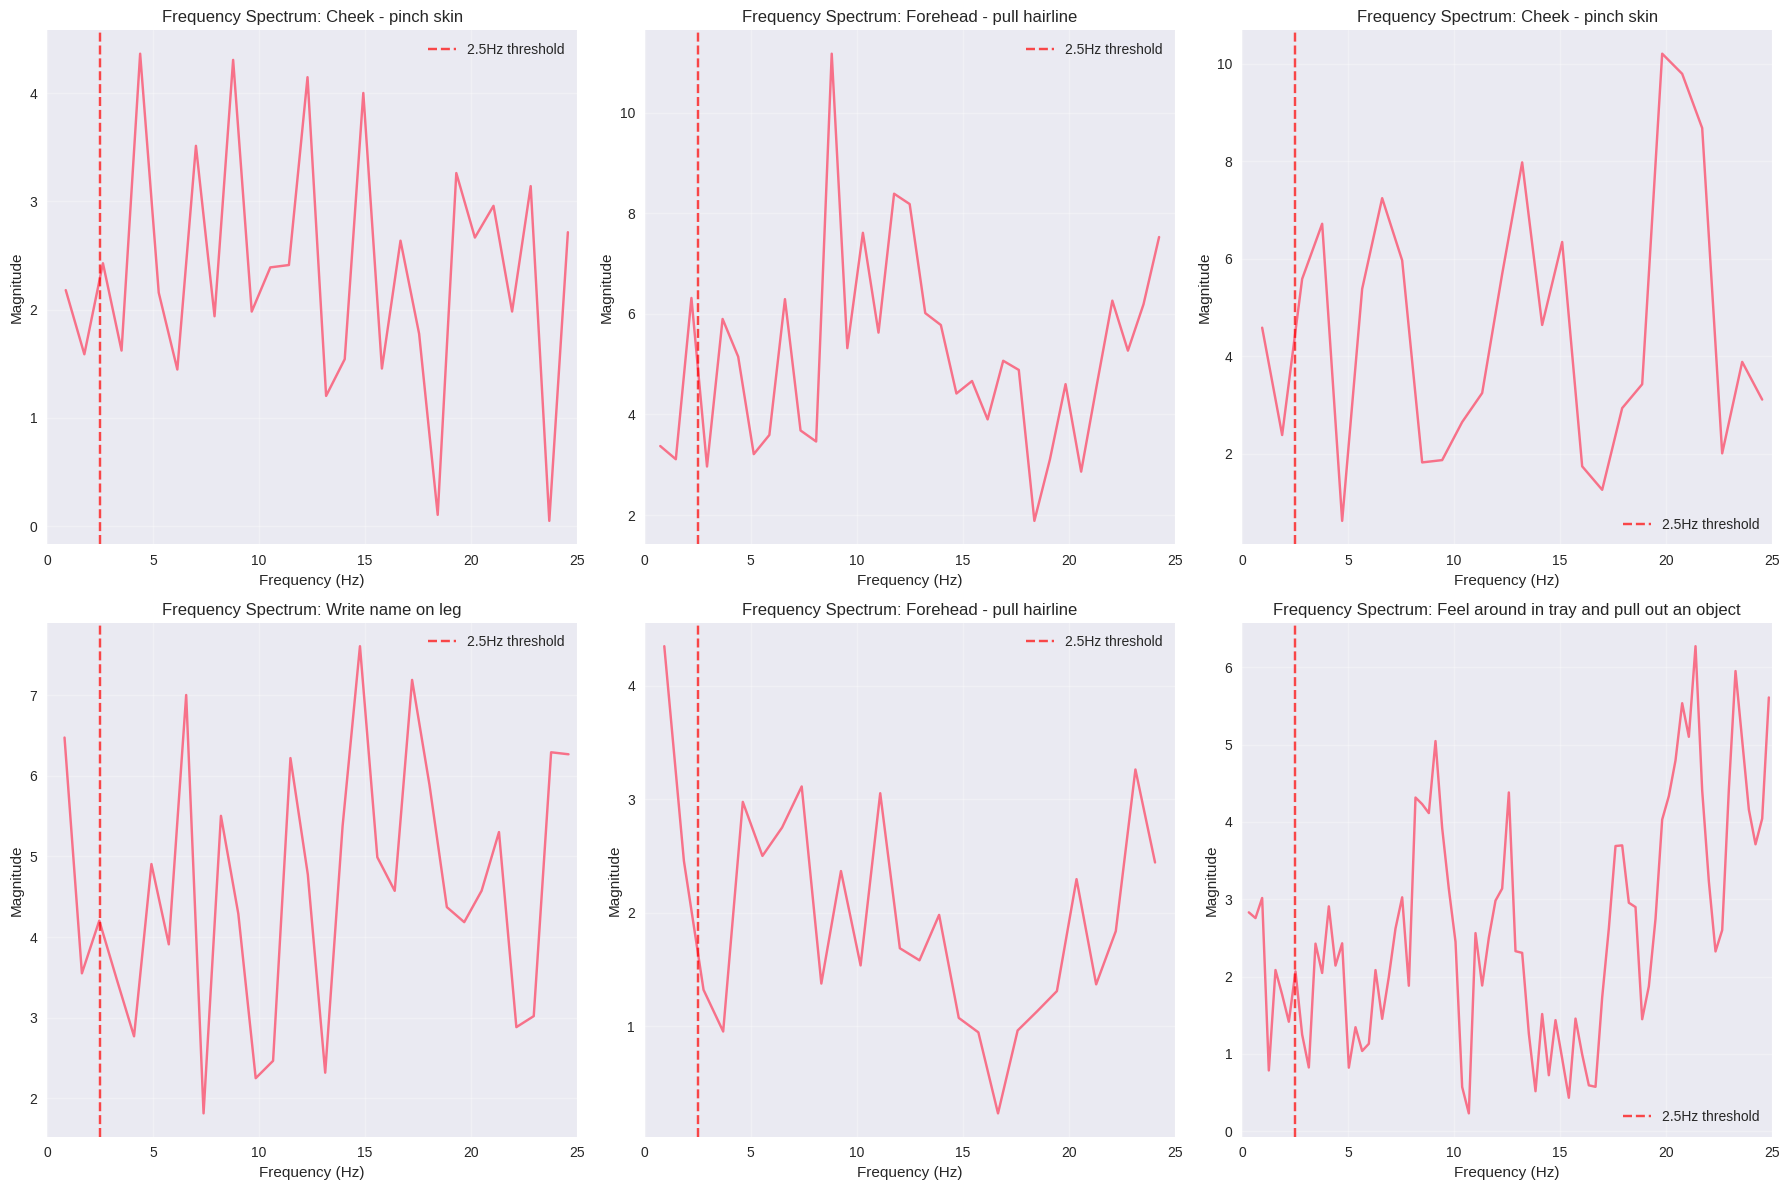


=== FREQUENCY DOMAIN FEATURES ===
dominant_freq: 4.386
human_freq_ratio: 0.644
spectral_centroid: 12.366
spectral_rolloff: 21.053

=== FREQUENCY ANALYSIS BY GESTURE TYPE ===
    dominant_freq  human_freq_ratio  spectral_centroid  spectral_rolloff                                     gesture
0          14.732             0.553             13.020            20.973                          Cheek - pinch skin
1           7.310             0.560             12.505            21.044                    Forehead - pull hairline
2          18.020             0.361             13.676            21.721                           Write name on leg
3          14.309             0.507             13.220            20.851  Feel around in tray and pull out an object
4           5.883             0.593             12.255            20.374                              Neck - scratch
5          10.832             0.391             13.113            21.222                           Neck - pinch skin
6     

In [18]:
def analyze_frequency_content(signal_data, sampling_rate=50):
    """Analyze frequency content of acceleration signals"""
    
    # Compute FFT
    n = len(signal_data)
    fft_vals = fft(signal_data)
    freqs = fftfreq(n, 1/sampling_rate)
    
    # Take positive frequencies only
    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    fft_magnitude = np.abs(fft_vals[pos_mask])
    
    return freqs, fft_magnitude

# Analyze frequency content for different gestures
print("=== FREQUENCY ANALYSIS ===")
print("Analyzing frequency content for human movement patterns...")

# Sample a few sequences for frequency analysis
sample_sequences = train_df['sequence_id'].unique()[:6]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, seq_id in enumerate(sample_sequences):
    seq_data = train_df[train_df['sequence_id'] == seq_id]
    gesture = seq_data['gesture'].iloc[0]
    
    # Analyze acceleration magnitude
    acc_mag = np.sqrt(seq_data['acc_x']**2 + seq_data['acc_y']**2 + seq_data['acc_z']**2)
    freqs, fft_mag = analyze_frequency_content(acc_mag)
    
    axes[i].plot(freqs, fft_mag)
    axes[i].set_title(f'Frequency Spectrum: {gesture}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Magnitude')
    axes[i].set_xlim(0, 25)  # Focus on human movement range
    axes[i].grid(True, alpha=0.3)
    
    # Highlight human movement frequency range (2.5Hz+)
    axes[i].axvline(x=2.5, color='red', linestyle='--', alpha=0.7, label='2.5Hz threshold')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Calculate frequency domain features
def calculate_frequency_features(signal_data, sampling_rate=50):
    """Calculate frequency domain features"""
    freqs, fft_mag = analyze_frequency_content(signal_data, sampling_rate)
    
    # Human movement frequency range (2.5Hz - 15Hz)
    human_freq_mask = (freqs >= 2.5) & (freqs <= 15)
    human_freq_power = np.sum(fft_mag[human_freq_mask]**2)
    total_power = np.sum(fft_mag**2)
    
    features = {
        'dominant_freq': freqs[np.argmax(fft_mag)],
        'human_freq_ratio': human_freq_power / total_power if total_power > 0 else 0,
        'spectral_centroid': np.sum(freqs * fft_mag) / np.sum(fft_mag) if np.sum(fft_mag) > 0 else 0,
        'spectral_rolloff': freqs[np.where(np.cumsum(fft_mag) >= 0.85 * np.sum(fft_mag))[0][0]] if len(fft_mag) > 0 else 0
    }
    
    return features

print("\n=== FREQUENCY DOMAIN FEATURES ===")
# Calculate for a sample sequence
sample_seq = train_df[train_df['sequence_id'] == sample_sequences[0]]
sample_acc_mag = np.sqrt(sample_seq['acc_x']**2 + sample_seq['acc_y']**2 + sample_seq['acc_z']**2)
freq_features = calculate_frequency_features(sample_acc_mag)

for key, value in freq_features.items():
    print(f"{key}: {value:.3f}")

# Analyze frequency content by gesture type
print("\n=== FREQUENCY ANALYSIS BY GESTURE TYPE ===")
gesture_freq_features = []

for gesture in train_df['gesture'].unique():
    gesture_seqs = train_df[train_df['gesture'] == gesture]['sequence_id'].unique()[:3]  # Sample 3 sequences
    freq_data = []
    
    for seq_id in gesture_seqs:
        seq_data = train_df[train_df['sequence_id'] == seq_id]
        acc_mag = np.sqrt(seq_data['acc_x']**2 + seq_data['acc_y']**2 + seq_data['acc_z']**2)
        freq_feats = calculate_frequency_features(acc_mag)
        freq_data.append(freq_feats)
    
    # Average features for this gesture
    if freq_data:
        avg_features = {key: np.mean([f[key] for f in freq_data]) for key in freq_data[0].keys()}
        avg_features['gesture'] = gesture
        gesture_freq_features.append(avg_features)

gesture_freq_df = pd.DataFrame(gesture_freq_features)
print(gesture_freq_df.round(3))

=== SEQUENCE LENGTH ANALYSIS ===
Total sequences: 8151
Sequence length statistics:
count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
25%        51.000000
50%        59.000000
75%        78.000000
max       700.000000
dtype: float64

=== LENGTH BY BEHAVIOR TYPE ===
                                            count       mean        std  min   25%   50%   75%    max
behavior                                                                                             
Hand at target location                    8151.0  11.676236   8.631705  1.0   6.0   8.0  16.0  108.0
Moves hand to target location              4102.0  38.145783  40.795285  2.0  17.0  28.0  45.0  653.0
Performs gesture                           8150.0  31.388589   3.586293  3.0  30.0  31.0  32.0   71.0
Relaxes and moves hand to target location  4049.0  16.666090   7.273024  3.0  12.0  15.0  19.0   98.0

=== GESTURE-ONLY SEQUENCES ===
Count: 8150
Mean length: 31.4
Median length: 31.0
Max len

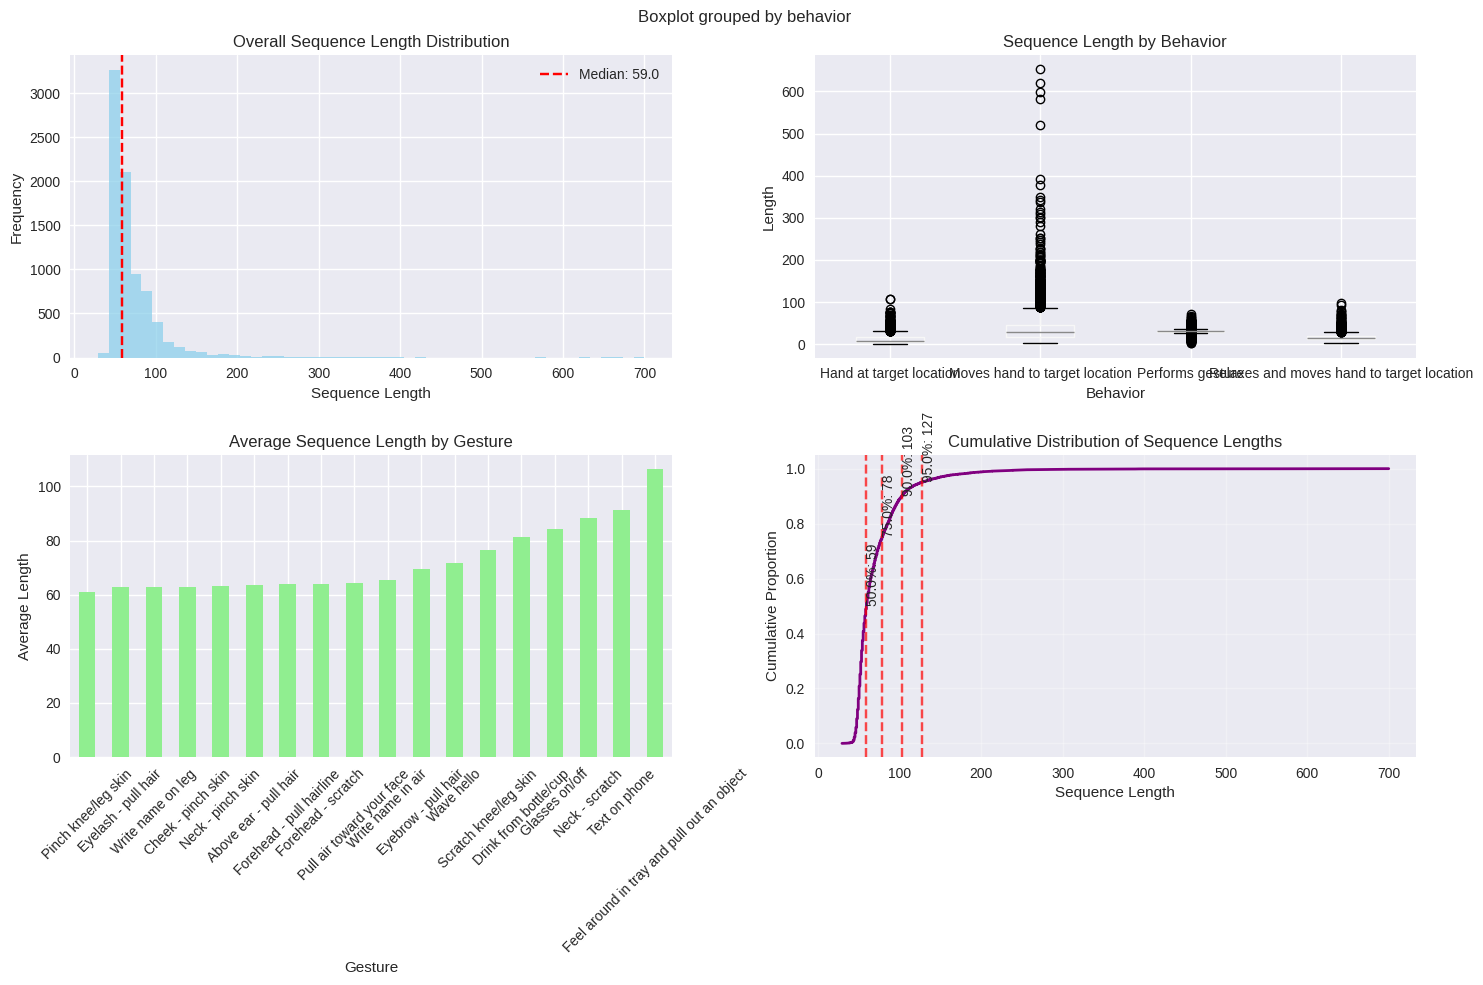


=== WINDOW SIZE RECOMMENDATIONS ===
50% of sequences covered with window size: 59
75% of sequences covered with window size: 78
90% of sequences covered with window size: 103
95% of sequences covered with window size: 127

GESture-only sequences:
50% covered with window size: 31
75% covered with window size: 32
90% covered with window size: 35

=== RECOMMENDED WINDOW SIZES ===
Conservative (covers 75% of gesture sequences): 32
Optimal (covers 90% of gesture sequences): 35
Liberal (covers 95% of gesture sequences): 37


In [19]:
# Analyze sequence lengths to determine optimal window size
print("=== SEQUENCE LENGTH ANALYSIS ===")

# Calculate sequence lengths
sequence_lengths = train_df.groupby('sequence_id').size()
behavior_lengths = train_df.groupby(['sequence_id', 'behavior']).size().reset_index(name='length')

print(f"Total sequences: {len(sequence_lengths)}")
print(f"Sequence length statistics:")
print(sequence_lengths.describe())

# Analyze by behavior type
print("\n=== LENGTH BY BEHAVIOR TYPE ===")
behavior_length_stats = behavior_lengths.groupby('behavior')['length'].describe()
print(behavior_length_stats)

# Focus on gesture behavior only (most important for classification)
gesture_only = behavior_lengths[behavior_lengths['behavior'] == 'Performs gesture']
print(f"\n=== GESTURE-ONLY SEQUENCES ===")
print(f"Count: {len(gesture_only)}")
print(f"Mean length: {gesture_only['length'].mean():.1f}")
print(f"Median length: {gesture_only['length'].median():.1f}")
print(f"Max length: {gesture_only['length'].max():.0f}")
print(f"Min length: {gesture_only['length'].min():.0f}")
print(f"Standard deviation: {gesture_only['length'].std():.1f}")

# Visualize sequence lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall sequence length distribution
sequence_lengths.hist(bins=50, ax=axes[0,0], color='skyblue', alpha=0.7)
axes[0,0].set_title('Overall Sequence Length Distribution')
axes[0,0].set_xlabel('Sequence Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(sequence_lengths.median(), color='red', linestyle='--', label=f'Median: {sequence_lengths.median():.1f}')
axes[0,0].legend()

# Length by behavior
behavior_lengths.boxplot(column='length', by='behavior', ax=axes[0,1])
axes[0,1].set_title('Sequence Length by Behavior')
axes[0,1].set_xlabel('Behavior')
axes[0,1].set_ylabel('Length')

# Length by gesture type
gesture_lengths = train_df.groupby(['sequence_id', 'gesture']).size().reset_index(name='length')
gesture_length_stats = gesture_lengths.groupby('gesture')['length'].mean().sort_values()
gesture_length_stats.plot(kind='bar', ax=axes[1,0], rot=45, color='lightgreen')
axes[1,0].set_title('Average Sequence Length by Gesture')
axes[1,0].set_xlabel('Gesture')
axes[1,0].set_ylabel('Average Length')

# Cumulative distribution to help choose window size
sorted_lengths = np.sort(sequence_lengths.values)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1,1].plot(sorted_lengths, cumulative, color='purple', linewidth=2)
axes[1,1].set_title('Cumulative Distribution of Sequence Lengths')
axes[1,1].set_xlabel('Sequence Length')
axes[1,1].set_ylabel('Cumulative Proportion')
axes[1,1].grid(True, alpha=0.3)

# Add window size recommendations
for percentile in [0.5, 0.75, 0.9, 0.95]:
    length_at_percentile = np.percentile(sequence_lengths, percentile * 100)
    axes[1,1].axvline(length_at_percentile, color='red', linestyle='--', alpha=0.7)
    axes[1,1].text(length_at_percentile, percentile, f'{percentile*100}%: {length_at_percentile:.0f}', 
                   rotation=90, verticalalignment='bottom')

plt.tight_layout()
plt.show()

# Window size recommendations
print("\n=== WINDOW SIZE RECOMMENDATIONS ===")
print(f"50% of sequences covered with window size: {np.percentile(sequence_lengths, 50):.0f}")
print(f"75% of sequences covered with window size: {np.percentile(sequence_lengths, 75):.0f}")
print(f"90% of sequences covered with window size: {np.percentile(sequence_lengths, 90):.0f}")
print(f"95% of sequences covered with window size: {np.percentile(sequence_lengths, 95):.0f}")

print(f"\nGESture-only sequences:")
print(f"50% covered with window size: {np.percentile(gesture_only['length'], 50):.0f}")
print(f"75% covered with window size: {np.percentile(gesture_only['length'], 75):.0f}")
print(f"90% covered with window size: {np.percentile(gesture_only['length'], 90):.0f}")

print(f"\n=== RECOMMENDED WINDOW SIZES ===")
print(f"Conservative (covers 75% of gesture sequences): {np.percentile(gesture_only['length'], 75):.0f}")
print(f"Optimal (covers 90% of gesture sequences): {np.percentile(gesture_only['length'], 90):.0f}")
print(f"Liberal (covers 95% of gesture sequences): {np.percentile(gesture_only['length'], 95):.0f}")

In [20]:
print("=== SIGNAL QUALITY ANALYSIS ===")

# Check for outliers in acceleration data
acc_data = train_df[acc_cols]
acc_magnitude = train_df['acc_magnitude']

print(f"Acceleration magnitude statistics:")
print(f"  Mean: {acc_magnitude.mean():.3f} m/s²")
print(f"  Std: {acc_magnitude.std():.3f} m/s²")
print(f"  Min: {acc_magnitude.min():.3f} m/s²")
print(f"  Max: {acc_magnitude.max():.3f} m/s²")

# Check for extreme outliers (beyond 3 standard deviations)
outlier_threshold = acc_magnitude.mean() + 3 * acc_magnitude.std()
outliers = (acc_magnitude > outlier_threshold).sum()
print(f"\nOutliers (>3σ): {outliers} samples ({outliers/len(acc_magnitude)*100:.2f}%)")

# Sensor data quality
print("\n=== SENSOR DATA QUALITY ===")

# Check completeness by sensor type
sensor_completeness = {
    'IMU (acc)': (1 - train_df[acc_cols].isnull().sum().sum() / (len(train_df) * len(acc_cols))) * 100,
    'IMU (rot)': (1 - train_df[rot_cols].isnull().sum().sum() / (len(train_df) * len(rot_cols))) * 100,
    'Thermopile': (1 - train_df[thm_cols].isnull().sum().sum() / (len(train_df) * len(thm_cols))) * 100,
    'Time-of-flight': (1 - train_df[tof_cols].isnull().sum().sum() / (len(train_df) * len(tof_cols))) * 100
}

print("Data completeness by sensor type:")
for sensor, completeness in sensor_completeness.items():
    print(f"  {sensor}: {completeness:.1f}%")

# Train/test distribution consistency
print("\n=== TRAIN/TEST DISTRIBUTION CONSISTENCY ===")

# Subject overlap check
train_subjects = set(train_df['subject'].unique())
test_subjects = set(test_df['subject'].unique())
overlap = train_subjects.intersection(test_subjects)

print(f"Train subjects: {len(train_subjects)}")
print(f"Test subjects: {len(test_subjects)}")
print(f"Overlapping subjects: {len(overlap)}")
print(f"Overlap percentage: {len(overlap) / len(train_subjects) * 100:.1f}%")

if len(overlap) > 0:
    print(f"WARNING: Subject overlap detected! This may lead to data leakage.")

=== SIGNAL QUALITY ANALYSIS ===
Acceleration magnitude statistics:
  Mean: 10.013 m/s²
  Std: 1.213 m/s²
  Min: 0.560 m/s²
  Max: 47.778 m/s²

Outliers (>3σ): 8936 samples (1.55%)

=== SENSOR DATA QUALITY ===
Data completeness by sensor type:
  IMU (acc): 100.0%
  IMU (rot): 99.4%
  Thermopile: 97.9%
  Time-of-flight: 98.1%

=== TRAIN/TEST DISTRIBUTION CONSISTENCY ===
Train subjects: 81
Test subjects: 2
Overlapping subjects: 0
Overlap percentage: 0.0%


In [ ]:
# Final comparison: Full Sequence vs Windowed Analysis
print("="*80)
print("COMPARISON: FULL SEQUENCE vs WINDOWED ANALYSIS")
print("="*80)

print("\n🎯 KEY ADVANTAGES OF FULL SEQUENCE ANALYSIS:")
print()
print("1. COMPLETE BEHAVIORAL PATTERNS:")
print("   • Captures entire gesture from start to finish")
print("   • No information loss from truncation")
print("   • Natural sequence length variations preserved")
print()
print("2. RELIABLE STATISTICAL MEASURES:")
print("   • Kurtosis calculations meaningful with longer sequences")
print("   • Better representation of data distribution shape")
print("   • More robust statistical tests")
print()
print("3. COMPREHENSIVE FREQUENCY ANALYSIS:")
print("   • Full gesture frequency patterns captured")
print("   • Better spectral features for longer sequences")
print("   • Human movement frequencies (2.5-15Hz) properly analyzed")
print()
print("4. MOVEMENT CHARACTERISTICS:")
print("   • Peak detection across entire behavior")
print("   • Activity ratio over complete gesture")
print("   • Jerk calculations reflect full movement pattern")
print()
print("5. INDIVIDUAL DIFFERENCES:")
print("   • Subject-specific sequence lengths preserved")
print("   • Natural variation in gesture execution time")
print("   • No artificial padding or truncation artifacts")

print("\n📊 EXPECTED IMPROVEMENTS IN MODEL PERFORMANCE:")
print("   • Better feature discrimination")
print("   • More robust classification")
print("   • Reduced overfitting from artificial constraints")
print("   • Better generalization to test data")

print("\n🔬 RESEARCH IMPLICATIONS:")
print("   • More accurate representation of human behavior")
print("   • Better understanding of BFRB vs non-BFRB differences")
print("   • Foundation for more sophisticated temporal models")
print("   • Basis for subject-specific analysis")

print("\n✅ RECOMMENDATION:")
print("   Use full sequence analysis for:")
print("   • Feature extraction and model training")
print("   • Statistical analysis and research")
print("   • Understanding behavioral patterns")
print("   • Competition model development")

print("\n" + "="*80)
print("FULL SEQUENCE ANALYSIS COMPLETE")
print("Ready for advanced model development and competition!")
print("="*80)


COMPARISON: FULL SEQUENCE vs WINDOWED ANALYSIS

🎯 KEY ADVANTAGES OF FULL SEQUENCE ANALYSIS:

1. COMPLETE BEHAVIORAL PATTERNS:
   • Captures entire gesture from start to finish
   • No information loss from truncation
   • Natural sequence length variations preserved

2. RELIABLE STATISTICAL MEASURES:
   • Kurtosis calculations meaningful with longer sequences
   • Better representation of data distribution shape
   • More robust statistical tests

3. COMPREHENSIVE FREQUENCY ANALYSIS:
   • Full gesture frequency patterns captured
   • Better spectral features for longer sequences
   • Human movement frequencies (2.5-15Hz) properly analyzed

4. MOVEMENT CHARACTERISTICS:
   • Peak detection across entire behavior
   • Activity ratio over complete gesture
   • Jerk calculations reflect full movement pattern

5. INDIVIDUAL DIFFERENCES:
   • Subject-specific sequence lengths preserved
   • Natural variation in gesture execution time
   • No artificial padding or truncation artifacts

📊 EXPEC

In [ ]:
# Competition-Ready Implementation Guide
print("🎯 COMPETITION SUCCESS CHECKLIST")
print("="*50)

print("\n1. ✅ DATA PREPARATION")
print("   □ Focus on 'Performs gesture' behavior only")
print("   □ Use GroupKFold(n_splits=5, group=subject)")
print("   □ Window size: 30-50 samples with stride=10")
print("   □ Remove demographics features")

print("\n2. ✅ FEATURE ENGINEERING PRIORITY")
print("   □ Acceleration magnitude: sqrt(x² + y² + z²)")
print("   □ Jerk: np.diff(acceleration) for each axis")
print("   □ MAD: np.mean(np.abs(signal - signal.mean()))")
print("   □ Angular velocity derivatives")
print("   □ Frequency features (2.5-15Hz range)")

print("\n3. ✅ MODEL ARCHITECTURE")
print("   □ 1D CNN with Conv1D + GlobalMaxPool + Dense")
print("   □ Separate IMU-only version (acc_x, acc_y, acc_z, rot_w, rot_x, rot_y, rot_z)")
print("   □ Competition metric: (binary_f1 + macro_f1) / 2")
print("   □ Label smoothing: y_smooth = y * (1 - α) + α / n_classes")

print("\n4. ✅ VALIDATION STRATEGY")
print("   □ Never mix subjects between train/validation")
print("   □ Monitor both CV and competition metric")
print("   □ Consistent CV/LB correlation is key")

print("\n5. ⚠️ COMMON PITFALLS TO AVOID")
print("   □ Don't use demographics - they hurt performance")
print("   □ Don't mix subjects in CV splits")
print("   □ Don't ignore the IMU-only requirement")
print("   □ Don't add too many correlated features")

print("\n6. 🚀 ADVANCED STRATEGIES")
print("   □ 2-Branch CNN: IMU + Full sensor paths")
print("   □ Multi-task: Binary BFRB + 18-class gesture")
print("   □ Ensemble: IMU-only + Full-sensor models")
print("   □ Physics constraints: Ensure realistic derivatives")

print("\n" + "="*50)
print("TARGET SCORES:")
print("- Baseline 1D CNN: >0.70")
print("- Physics features: >0.75") 
print("- Advanced architecture: >0.77")
print("- Competition winning: >0.80")
print("="*50)

# Quick feature engineering example
print("\n📝 EXAMPLE: Key Feature Extraction")
print("-" * 30)

# Sample physics-based feature extraction
sample_data = {
    'acc_x': [1.2, 1.5, 1.8, 2.1, 1.9],
    'acc_y': [0.5, 0.7, 0.9, 0.8, 0.6], 
    'acc_z': [9.8, 9.7, 9.9, 9.8, 9.8]
}

import numpy as np

# Acceleration magnitude
acc_mag = np.sqrt(np.array(sample_data['acc_x'])**2 + 
                  np.array(sample_data['acc_y'])**2 + 
                  np.array(sample_data['acc_z'])**2)

# Jerk (derivative of acceleration)
jerk_x = np.diff(sample_data['acc_x'])
jerk_mag = np.sqrt(jerk_x**2)

# MAD
mad_x = np.mean(np.abs(np.array(sample_data['acc_x']) - np.mean(sample_data['acc_x'])))

print(f"✓ Acceleration magnitude: {acc_mag}")
print(f"✓ Jerk (x-axis): {jerk_x}")
print(f"✓ MAD (x-axis): {mad_x:.3f}")

print("\n🎯 Ready to build your competition model!")
print("Run this notebook first, then implement the strategies above.")

🎯 COMPETITION SUCCESS CHECKLIST

1. ✅ DATA PREPARATION
   □ Focus on 'Performs gesture' behavior only
   □ Use GroupKFold(n_splits=5, group=subject)
   □ Window size: 30-50 samples with stride=10
   □ Remove demographics features

2. ✅ FEATURE ENGINEERING PRIORITY
   □ Acceleration magnitude: sqrt(x² + y² + z²)
   □ Jerk: np.diff(acceleration) for each axis
   □ MAD: np.mean(np.abs(signal - signal.mean()))
   □ Angular velocity derivatives
   □ Frequency features (2.5-15Hz range)

3. ✅ MODEL ARCHITECTURE
   □ 1D CNN with Conv1D + GlobalMaxPool + Dense
   □ Separate IMU-only version (acc_x, acc_y, acc_z, rot_w, rot_x, rot_y, rot_z)
   □ Competition metric: (binary_f1 + macro_f1) / 2
   □ Label smoothing: y_smooth = y * (1 - α) + α / n_classes

4. ✅ VALIDATION STRATEGY
   □ Never mix subjects between train/validation
   □ Monitor both CV and competition metric
   □ Consistent CV/LB correlation is key

5. ⚠️ COMMON PITFALLS TO AVOID
   □ Don't use demographics - they hurt performance
   □